<a href="https://colab.research.google.com/github/sjamthe/spacex-launch-analysis/blob/main/spacex_launch_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This parser downloads a spacex launch video from YouTube and parses launch parameters (speed, height, time)

## 1. Environment setup and library import

In [12]:
!pip install pytube

     |████████████████████████████████| 51kB 3.2MB/s 


In [1]:
!pip install easyocr

     |████████████████████████████████| 63.2MB 42kB/s 


In [20]:
from pytube import YouTube

In [ ]:
from google.colab.patches import cv2_imshow # for image display

from PIL import Image 


In [2]:
# Check is Link to Drive is OK
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi

Mounted at /content/GDrive/
Connection to Google drive successful


In [3]:
GDRIVE_TMP = '/content/GDrive/MyDrive/temp2'
!if [ -d {GDRIVE_TMP} ]; then echo "Output to be stored in "{GDRIVE_TMP} ; else mkdir -p {GDRIVE_TMP} && echo "Output directory created"; fi


Output to be stored in /content/GDrive/MyDrive/temp2


In [21]:
def download_video(url, folder=GDRIVE_TMP):
  return YouTube(url).streams.first().download(folder)

In [31]:
# skip=0 means extract all images, default 30 means 1 image per second for fps=30
import cv2 as cv2 
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pylab as plt

def extract_images(video, folder=GDRIVE_TMP, skip=30):
  count = 0
  success = True

  OUTPUT_FRAMES_PATH = folder + '/frames'      # Location of extracted images
  !if [ -d {OUTPUT_FRAMES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FRAMES_PATH} ; else mkdir -p {OUTPUT_FRAMES_PATH} && echo "Output directory created"; fi

  frame_name = 'frame'
  vidcap = cv2.VideoCapture(video)

  while success:
      if (skip == 0 or count%skip == 0):                                # checks frame number and keeps one_frame_each          
          success,image = vidcap.read()                                 # reads next frame           
          image_gray = rgb2gray(image)                                  # grayscale image
          if image.shape[1]>640:                                        # if image width > 640, resize it
            image_gray = resize(image_gray, (math.floor(640 / image_gray.shape[1] * image_gray.shape[0]), 640),mode='constant')
          plt.imsave("%s/%s%d.png" % (OUTPUT_FRAMES_PATH,frame_name, count), image_gray, cmap= plt.cm.gray) # saves images to frame folder
          #print ('*', end="")
      else:
          success,image = vidcap.read()                                 # reads next frame
      count += 1 
      
  return count                                                       # loops counter

In [14]:
# OCR all frames
import easyocr
import numpy as np

In [16]:
def ocr_scan(frame_cnt, skip=30):

  reader = easyocr.Reader(['en'],gpu=True)
  texts = []
  for cnt in range(frame_cnt):
    if (skip == 0 or cnt%skip == 0): 
      url = GDRIVE_TMP + '/frames/frame' + str(cnt) + '.png'
      bounds = reader.readtext(url, detail=1) 
      found_texts = np.array(bounds, dtype=object)[:,1]
      texts.append([cnt, found_texts, bounds])

  return texts

In [78]:
from PIL import ImageDraw, Image

# Draw bounding boxes
def draw_boxes(ocr_result, color='yellow', width=2):
    image_id = ocr_result[0]
    bounds = ocr_result[2]
    url = GDRIVE_TMP + '/frames/frame' + str(image_id) + '.png'
    image = Image.open(url)
    draw = ImageDraw.Draw(image)
    for bound in bounds: # iterate though all the tuples of output
        p0, p1, p2, p3 = bound[0] # get coordinates 
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

In [45]:
# Given 4 corners of a bounding box, return center
def get_bb_center(bb):
  x = 0
  y = 0
  for point in bb:
    x += point[0]
    y += point[1]
  return [int(x/4), int(y/4)]

In [101]:
# find bounding box that contains this point
def find_bb(bounding_boxes, point):
  for box in bounding_boxes:
    [a, b, c, d] = box[0]
    if point[0] > a[0] and point[0] < c[0] \
      and point[1] > a[1] and point[1] < c[1]:
        return box
  return None

In [95]:
# find stat points from good ocr result containing all stats only
def find_stat_point_center(good_ocr_result):
  bounds = good_ocr_result[2]
  #extract boxes
  stage1_speed, stage1_altitude, launch_time, stage2_speed, stage2_altitude = bounds
  stage1_speed_center = get_bb_center(stage1_speed[0])
  stage1_altitude_center = get_bb_center(stage1_altitude[0])
  launch_time_center = get_bb_center(launch_time[0])
  stage2_speed_center = get_bb_center(stage2_speed[0])
  stage2_altitude_center = get_bb_center(stage2_altitude[0])

  return [stage1_speed_center, stage1_altitude_center, launch_time_center, \
          stage2_speed_center, stage2_altitude_center]

In [87]:
# Test:
# find_stat_point_center(res[301])

[[55, 317], [109, 317], [320, 323], [529, 318], [584, 315]]

In [91]:
# calculate seconds from launch from clock text
def get_secs(clock_text):
  # some 0 can get parsed as O so lets replace them
  clock_text = clock_text.replace("O","0")
  clock_text = clock_text.replace("o","0")
  #separate hours
  hour_str = ""
  for i in range(len(clock_text)):
    if(clock_text[i].isnumeric()):
      hour_str += clock_text[i]
    else:
      break
  #separate minutes
  min_str = ""
  for j in range(i+1, len(clock_text)):
    if(clock_text[j].isnumeric()):
      min_str += clock_text[j]
    else:
      break
  #separate secs
  secs_str = ""
  for k in range(j+1, len(clock_text)):
    if(clock_text[k].isnumeric()):
      secs_str += clock_text[k]
    else:
      break
  #print(hour_str, min_str, secs_str)
  return int(hour_str)*3600+int(min_str)*60+int(secs_str)


In [90]:
# for each frame result find out the launch clock in the frame text
def parse_launch_time(ocr_result):
  frame = ocr_result[0]
  texts = ocr_result[1]
  for i in range(texts.size):
    if texts[i].startswith('T+'):
      #print ("after launch " + texts[i][2:])
      text = texts[i][2:]
      secs = get_secs(text)
      break
    else:
      secs = 0
  return frame, i, secs


In [232]:
# parse stage1, stage2 speed, altitude
def parse_launch_stats(ocr_result, loc_of_time):
  stage1_speed = 0
  stage1_altitude = 0
  stage2_speed = 0
  stage2_altitude = 0
  texts = ocr_result[1]
  #see if we may have stage1 stats
  if loc_of_time >= 2:
    if texts[loc_of_time-2].isnumeric():
      try:
        text = texts[loc_of_time-2].replace("(","")
        stage1_speed = int(text)
        text = texts[loc_of_time-1].replace("(","")
        stage1_altitude = float(text)
      except:
        stage1_speed = 0
        stage1_altitude = 0.0
    #print(stage1_speed, stage1_altitude, loc_of_time, texts)
  
  # see if we have stage2 stats
  if texts.size >= loc_of_time+2:
    if texts[loc_of_time+1].isnumeric(): 
      try:
        text = texts[loc_of_time+1].replace("(","")
        stage2_speed = int(text)
        text = texts[loc_of_time+2].replace("(","")
        stage2_altitude = float(text)
      except:
        stage2_speed = 0.0
        stage2_altitude = 0
    #print(stage2_speed, stage2_altitude, loc_of_time, texts)
 
  return stage1_speed, stage1_altitude, stage2_speed, stage2_altitude

In [200]:
import pandas as pd

#return pandas frame with index [stage1_speed, stage1_altitude, time_secs, stage2_speed, stage2_altitude]
def get_launch_stats(ocr_results):
  count = res.shape[0]
  data = []
  for cnt in range(count):
    frame, loc, secs = parse_launch_time(ocr_results[cnt])
    #print (frame, loc, secs, ocr_results[cnt][1])
    stage1_speed, stage1_altitude, stage2_speed, stage2_altitude = \
    parse_launch_stats(ocr_results[cnt], loc)
    data.append([stage1_speed, stage1_altitude, secs, stage2_speed, stage2_altitude])
    #print (stage1_speed, stage1_altitude, stage2_speed, stage2_altitude,ocr_results[cnt][1])
  
  df = pd.DataFrame (data, columns = ['stage1_speed', 'stage1_altitude',
                                      'time_secs', 'stage2_speed', 
                                      'stage2_altitude'])
  return df

In [127]:
# parse launch stats based on centers from good result
def get_stat_points(ocr_result, centers):
  frame, loc, secs = parse_launch_time(ocr_result)
  bounding_boxes = ocr_result[2]
  stage1_speed = None
  stage1_altitude = None
  stage2_speed = None
  stage2_altitude = None
  #look for centers in the result, add 0 if not found
  for i in range(len(centers)):
    center = centers[i]
    #skip time box as we have secs
    if i != 2:
      box = find_bb(bounding_boxes, center)
    else:
      box = None
    
    if box is None:
      val = None
      #print ("box not found for ", center)
    else:
      text = box[1]
      #cleanup text - we see ( and ,
      text = text.replace("(","")
      text = text.replace(",",".")
      text = text.replace("..",".")
      if text.isnumeric():
        val = float(text)
         #print ("read ", text)
      else:
        try:
          val = float(text)
        except:
          print ("skip non numeric" , text, " for text sequence " , i)
    # assign val to correct stats
    if i == 0:
      stage1_speed = val
    elif i == 1:
      stage1_altitude = val
    elif i == 3:
      stage2_speed = val
    elif i == 4:
      stage2_altitude = val

  return stage1_speed, stage1_altitude, secs, stage2_speed, stage2_altitude


In [128]:
import pandas as pd

# based on a good ocr result, 
# returns pandas frame with index [stage1_speed, stage1_altitude, time_secs, stage2_speed, stage2_altitude]
def get_launch_stats(good_ocr_result, ocr_results):
  
  centers = find_stat_point_center(good_ocr_result)
  
  data = []
  for ocr_result in ocr_results:
    stats = get_stat_points(ocr_result, centers)
    data.append(stats)
  
  df = pd.DataFrame (data, columns = ['stage1_speed', 'stage1_altitude',
                                      'time_secs', 'stage2_speed', 
                                      'stage2_altitude'])
  return df


In [130]:
# Test
df = get_launch_stats(res[301], res)

skip non numeric Lulmloovangulicll  for text sequence  4
skip non numeric 05cte5  for text sequence  4


# Execution

In [23]:
# Step 1: Download the video to GDrive
url = 'https://www.youtube.com/watch?v=_S99962hthY'
video = download_video(url)

In [32]:
# Step 2: Extract Images to GDrive
frame_cnt = extract_images(video)

Output to be stored in /content/GDrive/MyDrive/temp2/frames
******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [24]:
# Step 3: extract text with bounding boxes
texts = ocr_scan(frame_cnt)
results = np.array(texts, dtype=object)

In [45]:
# Step 4: save the results to GDrive
import pickle
pickle.dump(results, open( GDRIVE_TMP + '/results.p', "wb" ) )

In [4]:
# Step 5: Load saved results from GDrive
import pickle

res = pickle.load( open( GDRIVE_TMP + '/results.p', "rb" ) )

In [5]:
res.shape

(582, 3)

In [71]:
# find an image that has all correct boxes
# e.g approx image 301 seconds from launch has all 5 texts
bb = res[301]
bb

array([9030,
       array(['6990', '120', 'T+00.04.56', '(10741', '155'], dtype=object),
       list([([[37, 309], [73, 309], [73, 325], [37, 325]], '6990', 0.9930499196052551), ([[95, 309], [123, 309], [123, 325], [95, 325]], '120', 0.9999618019366884), ([[273, 313], [367, 313], [367, 333], [273, 333]], 'T+00.04.56', 0.5801435863491355), ([[507, 309], [551, 309], [551, 327], [507, 327]], '(10741', 0.8881978598067561), ([[569, 305], [599, 305], [599, 325], [569, 325]], '155', 0.9999943563098699)])],
      dtype=object)

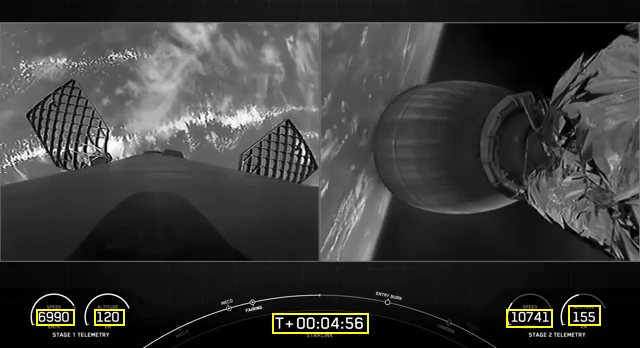

In [79]:
# draw boxes to verify image has only 5 boxes.
draw_boxes(res[301])

In [46]:
get_bb_center(bb)

[55, 317]

In [64]:
find_bb(bounding_boxes, get_bb_center(bb))

([[37, 309], [73, 309], [73, 325], [37, 325]], '6990', 0.9930499196052551)

In [198]:
parse_launch_time(res[301])

(9030, 2, 296)

In [233]:
df = get_launch_stats(res)

In [202]:
df.describe()

,stage1_speed,stage1_altitude,time_secs,stage2_speed,stage2_altitude
count,582.000000,582.000000,582.000000,582.000000,582.000000
mean,3872.821306,73.395876,285.757732,9500.158076,90.181787
std,3233.486086,401.805345,169.107106,9594.641510,78.321942
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,296.500000,0.925000,139.250000,0.000000,0.000000
50%,4199.000000,23.400000,285.500000,8652.000000,120.000000
75%,7081.250000,101.000000,431.750000,16729.000000,168.000000
max,13265.000000,7371.000000,578.000000,27199.000000,173.000000


In [131]:
df.describe()

,stage1_speed,stage1_altitude,time_secs,stage2_speed,stage2_altitude
count,508.000000,503.000000,582.000000,404.000000,403.000000
mean,5037.858268,56.593638,285.757732,15672.299505,154.470968
std,2725.351555,45.894218,169.107106,6616.921208,24.467320
min,114.000000,0.000000,0.000000,4044.000000,80.500000
25%,1859.000000,9.750000,139.250000,9876.000000,146.000000
50%,6948.000000,47.800000,285.500000,13819.000000,167.000000
75%,7240.000000,105.500000,431.750000,20955.000000,170.000000
max,8035.000000,123.000000,578.000000,27199.000000,173.000000


In [132]:
cleandf = df[(df.stage1_altitude < 130) &  (df.stage1_altitude > 0) & (df.stage1_speed < 8300)]

In [133]:
cleandf2 = df[(df.stage2_altitude > 0) & (df.stage2_speed > 5000)]

In [134]:
import seaborn as sns

# Apply the default theme
sns.set_theme()


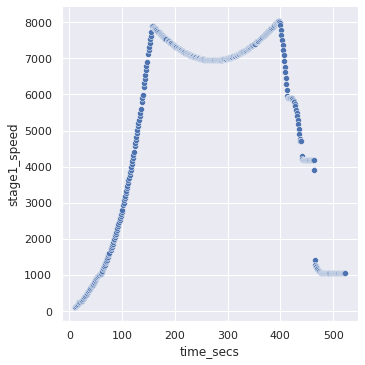

In [135]:
sns.relplot(x="time_secs", y="stage1_speed", data=cleandf);

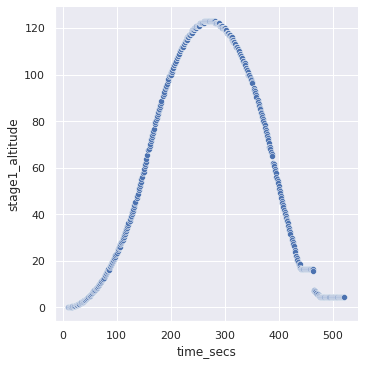

In [136]:
sns.relplot(x="time_secs", y="stage1_altitude", data=cleandf);

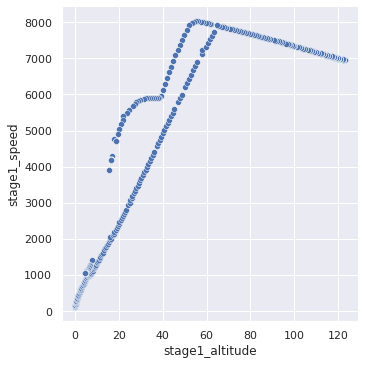

In [137]:
sns.relplot(y="stage1_speed", x="stage1_altitude", data=cleandf);

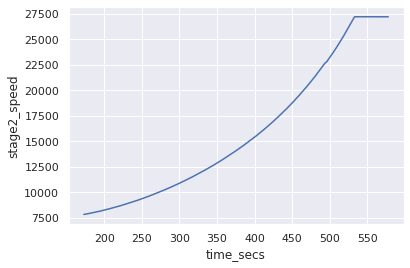

In [138]:
sns.lineplot(x="time_secs", y="stage2_speed", data=cleandf2);

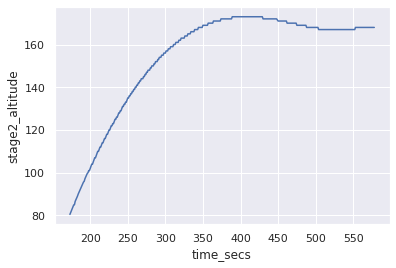

In [139]:
sns.lineplot(x="time_secs", y="stage2_altitude" , data=cleandf2);

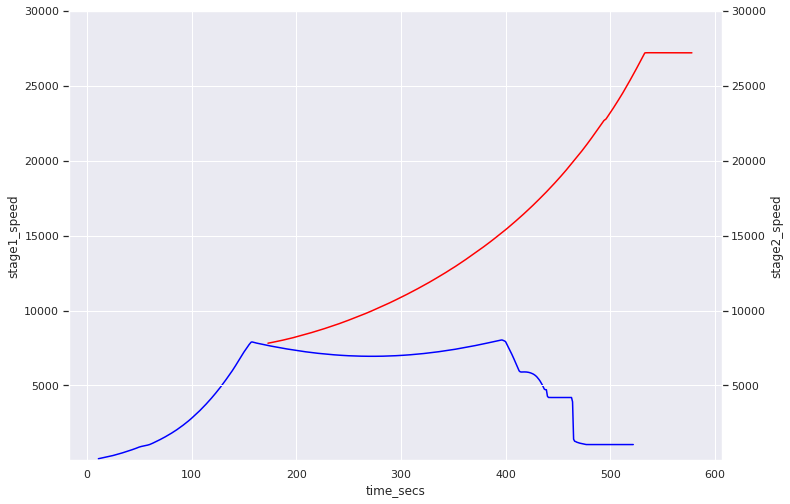

In [144]:
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax1 = plt.subplots() # initializes figure and plots
ax1.set(ylim=(10, 30000))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax2.set(ylim=(10, 30000))

sns.lineplot(x="time_secs", y="stage1_speed",ax = ax1, data=df, color='blue');
sns.lineplot(x="time_secs", y="stage2_speed",ax = ax2, data=cleandf2, color='red');

plt.show(); # shows the plot. 


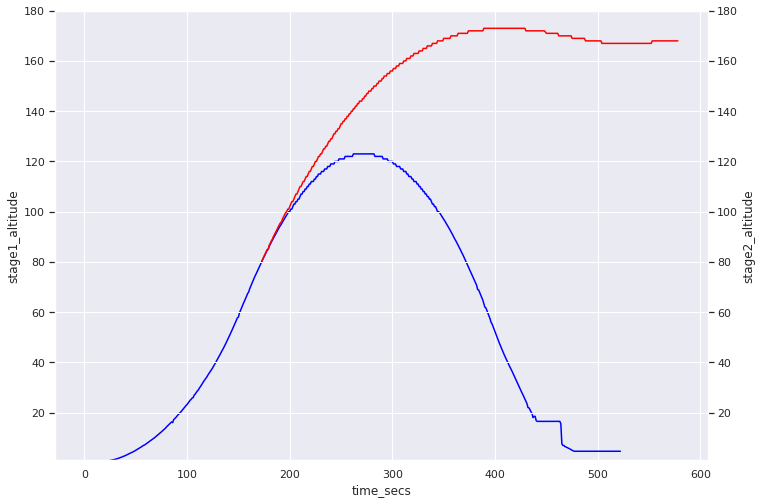

In [145]:
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax1 = plt.subplots() # initializes figure and plots
ax1.set(ylim=(1, 180))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax2.set(ylim=(1, 180))

sns.lineplot(x="time_secs", y="stage1_altitude",ax = ax1, data=df, color='blue');
sns.lineplot(x="time_secs", y="stage2_altitude",ax = ax2, data=cleandf2, color='red');

plt.show(); # shows the plot.

In [197]:
accdiff = df.stage1_speed.diff(10)
secdiff = df.time_secs.diff(10)
acc = accdiff/secdiff

In [198]:
cleandf['stage1_acc'] = acc
cleandf['stage1_g'] = acc/9.81

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [217]:
#calculate vertical velocity 
vertdiff = df.stage1_altitude.diff(10)
secdiff = df.time_secs.diff(10)
vert_vel = vertdiff/secdiff*1000
cleandf['vert_vel'] = vert_vel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [224]:
vertacc_diff = cleandf.vert_vel.diff(10)
secdiff = df.time_secs.diff(10)
vert_acc = vertacc_diff/secdiff
cleandf['vert_acc'] = vert_acc[vert_acc != 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [225]:
cleandf.describe()

,stage1_speed,stage1_altitude,time_secs,stage2_speed,stage2_altitude,stage1_acc,stage1_g,vert_vel,vert_acc
count,488.000000,488.000000,488.000000,337.000000,336.000000,478.000000,478.000000,469.000000,3.750000e+02
mean,5005.260246,58.333197,268.370902,13887.183976,152.895536,1.243553,0.126764,-10.634490,-4.381635e-01
std,2734.459842,45.491450,148.155129,5165.660917,25.074246,59.399269,6.054971,563.808256,2.465623e+01
min,114.000000,0.100000,11.000000,4044.000000,80.500000,-307.700000,-31.365953,-1100.000000,-1.100000e+02
25%,1773.000000,14.175000,138.750000,9543.000000,140.750000,-7.475000,-0.761978,-400.000000,-1.000000e+01
50%,6948.000000,52.100000,270.500000,12460.000000,167.000000,2.300000,0.234455,0.000000,-4.547474e-14
75%,7225.000000,107.000000,396.250000,17699.000000,171.000000,18.825000,1.918960,400.000000,6.909091e+00
max,8035.000000,123.000000,522.000000,25750.000000,173.000000,113.200000,11.539246,1027.272727,1.010000e+02


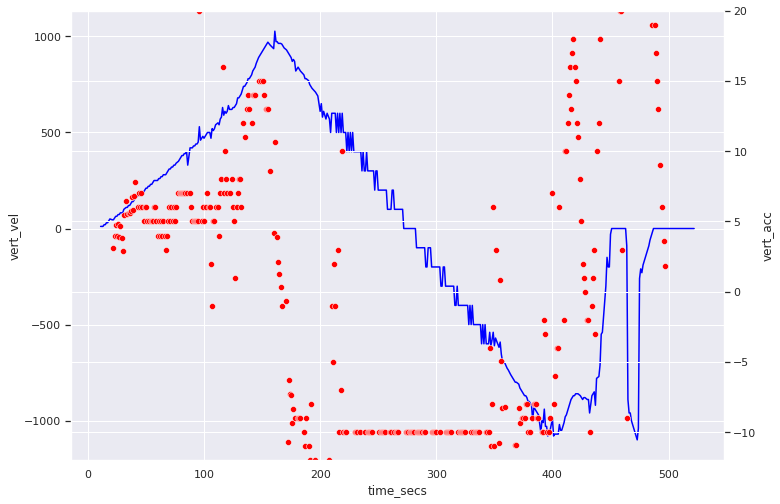

In [227]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax1 = plt.subplots() # initializes figure and plots
#ax1.set(ylim=(-32, 12))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax2.set(ylim=(-12, 20))

sns.lineplot(x="time_secs", y="vert_vel",ax=ax1, data=cleandf, color='blue');
sns.scatterplot(x="time_secs", y="vert_acc",ax = ax2, data=cleandf, color='red');
plt.show(); # shows the plot.

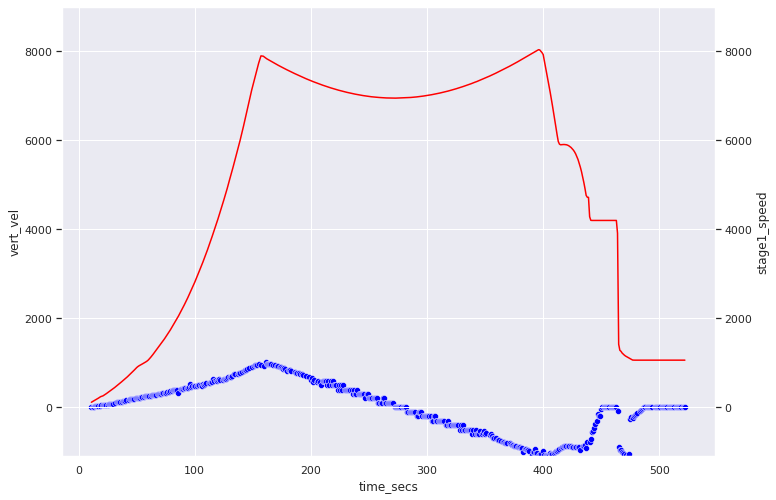

In [232]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax1 = plt.subplots() # initializes figure and plots
ax1.set(ylim=(-1100, 9000))

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
ax2.set(ylim=(-1100, 9000))

sns.scatterplot(x="time_secs", y="vert_vel",ax=ax1, data=cleandf, color='blue');
sns.lineplot(x="time_secs", y="stage1_speed",ax = ax2, data=cleandf, color='red');
plt.show(); # shows the plot.